# Setting Up and Connecting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


#change pathway as needed
import os
os.chdir('/content/drive/MyDrive/DLproject/DLproject/NeuralVoiceCloning/StyleTTS2')


Mounted at /content/drive


In [ ]:
#!git clone https://huggingface.co/yl4579/StyleTTS2-LJSpeech

# Functions to Load, Preprocess, and Compute Mean Squared Error (MSE) Loss

In [7]:
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set up mel + dB transforms
mel_transform = T.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    hop_length=256,
    n_mels=80
)
amp_to_db = T.AmplitudeToDB()

# Load wav and convert to normalized dB-scale mel
def load_normalized_mel(path):
    waveform, sr = torchaudio.load(path)
    if sr != 24000:
        resample = T.Resample(sr, 24000)
        waveform = resample(waveform)
    mel = mel_transform(waveform)
    mel_db = amp_to_db(mel)
    mel_db = mel_db.squeeze(0)
    mel_db = mel_db / mel_db.max()  # Option 1-style normalization
    return mel_db

# Compute MSE between two mel specs
def compute_mse_aligned(mel1, mel2):
    min_t = min(mel1.shape[1], mel2.shape[1])
    mel1, mel2 = mel1[:, :min_t], mel2[:, :min_t]
    return F.mse_loss(mel1, mel2).item()

# Load and compare, change pathway as needed
# i.e. "Models/Samples/with-slm-discriminator" aligning with repo
mel_a = load_normalized_mel("Models/Custom/with-slm-discriminator.wav")
mel_b = load_normalized_mel("Models/Custom/no-slm-discriminator.wav")
mel_c = load_normalized_mel("Models/Custom/ground-truth-eval.wav")

# Calculating Mean Squared Error Loss

In [9]:

mse_gt_vs_no = compute_mse_aligned(mel_c, mel_b)
mse_gt_vs_with = compute_mse_aligned(mel_c, mel_a)
mse_no_vs_with = compute_mse_aligned(mel_b, mel_a)

print(f"MSE Loss - Ground Truth vs. Without SLM Discriminator: {mse_gt_vs_no:.6f}")
print(f"MSE Loss - Ground Truth vs With SLM Discriminator : {mse_gt_vs_with:.6f}")
print(f"MSE Loss - Without SLM Discriminator vs With SLM Discriminator: {mse_no_vs_with:.6f}")

MSE Loss - Ground Truth vs. Without SLM Discriminator: 0.350114
MSE Loss - Ground Truth vs With SLM Discriminator : 0.504631
MSE Loss - Without SLM Discriminator vs With SLM Discriminator: 0.250794


# Qualitative Visualization - Mel Spectrograms

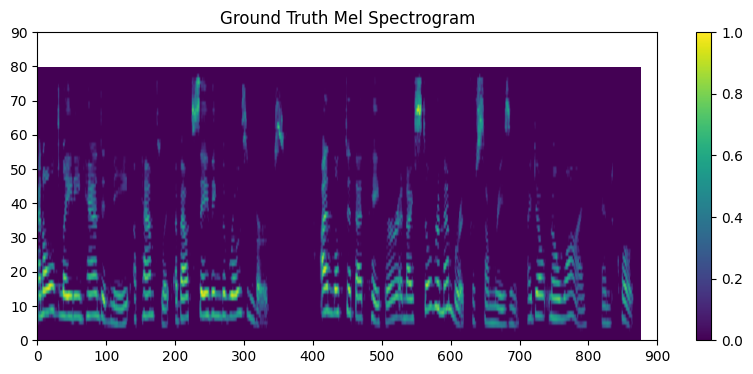

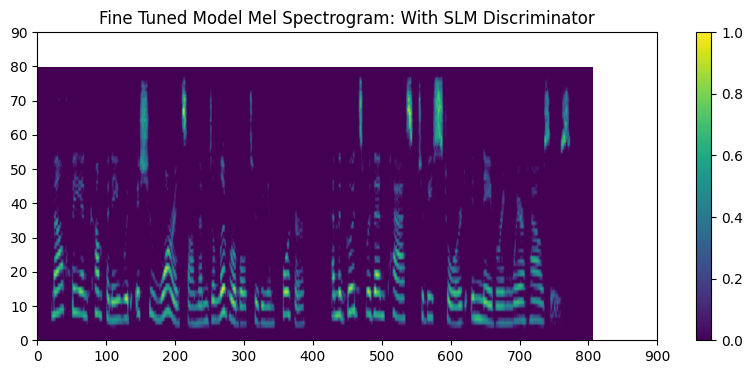

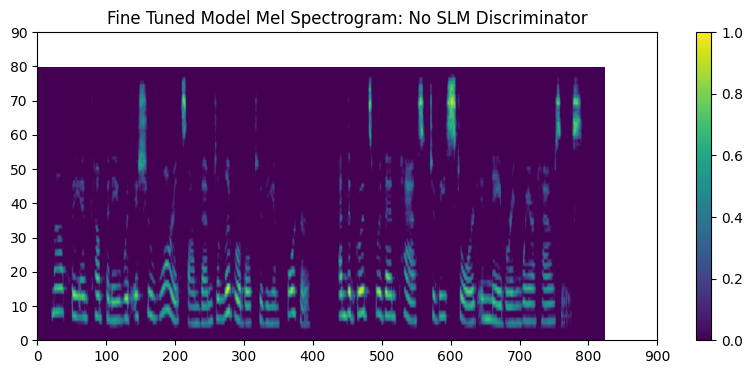

In [12]:
# Plot
vmin = 0
vmax = max(mel_a.max().item(), mel_b.max().item(), mel_c.max().item())

xmin = 0
xmax = max(mel_a.max().item(), mel_b.max().item(), mel_c.max().item())

# ground truth
plt.figure(figsize=(10, 4))
plt.imshow(mel_c.numpy(), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.xlim(0, 900)
plt.ylim(0, 90)
plt.title("Ground Truth Mel Spectrogram")
plt.colorbar()
plt.show()

# no slm
plt.figure(figsize=(10, 4))
plt.imshow(mel_a.numpy(), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.xlim(0, 900)
plt.ylim(0, 90)
plt.title("Fine Tuned Model Mel Spectrogram: With SLM Discriminator")
plt.colorbar()
plt.show()

# with slm
plt.figure(figsize=(10, 4))
plt.imshow(mel_b.numpy(), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.xlim(0, 900)
plt.ylim(0, 90)
plt.title("Fine Tuned Model Mel Spectrogram: No SLM Discriminator")
plt.colorbar()
plt.show()